# 1. data import & preprocessing 

In [1]:
import numpy as np
import pandas as pd

### 1) dataset 불러오기
* data50: train set
* data25: test set

In [2]:
data25 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/feature25.csv")
data50 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/feature50.csv")

data25['is_bump40'] = data25['shortest_bump_dist'] < 40
data50['is_bump40'] = data50['shortest_bump_dist'] < 40

data25['is_sidewalk25'] = data25['shortest_sidewalk_dist'] < 25
data50['is_sidewalk25'] = data50['shortest_sidewalk_dist'] < 25

## 2) 사용할 변수 선언

In [3]:
col = {"x_common": ['overspeed_cam_count100', 'floating_pop_count50','car_count1000', 'child_count1000', 
                  'elem_kinder_count400','num_cram_school_count400', 
                  'shortest_cross_dist','shortest_traffic_signal_dist',],
       "x_25" : ['is_bump40', 'parking_count25','is_sidewalk25', 'barrier_nearby_count25',
                   'chaos1_nearby_count25', 'width_nearby_count25','cross_road_nearby_count25',
                   ],
       "x_50" : ['is_bump40', 'parking_count25','is_sidewalk25', 'barrier_nearby_count25',
                   'chaos1_nearby_count25', 'width_nearby_count25','cross_road_nearby_count25'],
       "y_25" : 'accident_count12.5',
       "y_50" : 'accident_count25'}

xy50 = data50[col["x_common"] + col["x_50"] +[col['y_50']]].astype(float)
xy25 = data25[col["x_common"] + col["x_25"] +[col['y_25']]].astype(float)

xy50[col['y_50']] = (xy50[col['y_50']] > 0).astype(float)
xy25[col['y_25']] = (xy25[col['y_25']] > 0).astype(float)

## 3) 사전에 진행한 cluster data 불러오기

In [4]:
kmeans50 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/kmeans_cluster50.csv")
kmeans25 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/kmeans_cluster25.csv")

In [5]:
print(xy50.shape)
print(kmeans50.shape)
print(xy25.shape)
print(kmeans25.shape)

(3912, 16)
(3912, 1)
(7636, 16)
(7636, 1)


## 4) dataset 합치기

In [6]:
xy50=pd.concat([xy50, kmeans50], axis=1)
xy50.rename(columns={'0':'cluster'}, inplace=True)

xy25=pd.concat([xy25, kmeans25], axis=1)
xy25.rename(columns={'0':'cluster'}, inplace=True)

## 5) 사고 방지 장치 데이터 삭제 (도로 자체만의 특성만 반영하기 위해)

In [7]:
xy_train=xy50.drop(['overspeed_cam_count100', 'is_bump40'], axis=1)
xy_test=xy25.drop(['overspeed_cam_count100', 'is_bump40'], axis=1)

## 6) 열 이름 통일 (열 이름이 다르면, model train 후 predict할 때 오류 뜸)

In [8]:
xy_train.rename(columns={'parking_count25':'parking_count', 'is_sidewalk25':'is_sidewalk',
                    'barrier_nearby_count25':'barrier_nearby_count', 'chaos1_nearby_count25':'chaos1_nearby_count',
                     'width_nearby_count25':'width_nearby_count', 'cross_road_nearby_count25':'cross_road_nearby_count',
                     'accident_count25':'accident_count'},inplace=True)
xy_test.rename(columns={'parking_count25':'parking_count', 'is_sidewalk25':'is_sidewalk',
                    'barrier_nearby_count25':'barrier_nearby_count', 'chaos1_nearby_count25':'chaos1_nearby_count',
                     'width_nearby_count25':'width_nearby_count', 'cross_road_nearby_count25':'cross_road_nearby_count',
                     'accident_count12.5':'accident_count'},inplace=True)

## 7) X, y split

In [10]:
X_train=xy_train.drop(['accident_count'], axis=1)
y_train=xy_train['accident_count']

X_test=xy_test.drop(['accident_count'], axis=1)
y_test=xy_test['accident_count']

# 2. Model - XGB Classifier

In [11]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE # unbalanced dataset을 학습시키기 위해, smote 사용하여 oversampling(train set만)

## 1) smote를 이용하여 oversampling (불균형 data를 조정)

In [13]:
sm = SMOTE()
X_resampled, y_resampled = sm.fit_sample(X_train, y_train)

## 2) gridsearchCV로 parameter tuning + model training (scoring은 auc_roc로 진행)

In [17]:
xgb=XGBClassifier()

xgb_param_grid={
    'n_estimators':[1000, 1500],
    'learning_rate':[0.01, 0.05, 0.1],
    'max_depth':[3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.3],
    'objective': ['binary:logistic']
}

xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=3)
xgb_grid.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 68.3min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 91.9min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed: 118.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 155.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 192.6min
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed: 235.5min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed: 295.2min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed: 360.3min
[Parallel(n_jobs=-1)]: Done 5832 out of 5832 | elapsed: 391.2min finished
C:\Users\ishon\anaconda3\lib\s

[04:09:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.

In [18]:
print('best score : {0:.4f}'.format(xgb_grid.best_score_)) #auc_roc
print('best param : ', xgb_grid.best_params_)

best score : 0.9821
best param :  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1500, 'objective': 'binary:logistic', 'subsample': 0.9}


## 3) f1 score와 confusion matrix 살펴보기

In [19]:
xgb_model = xgb_grid.best_estimator_
xgb_pred = xgb_model.predict(X_test)

In [43]:
print(f1_score(y_test, xgb_pred))
confusion_matrix(y_test, xgb_pred)

0.4864864864864864


array([[7188,  253],
       [  51,  144]], dtype=int64)

In [41]:
print(f1_score(y_test, xgb_pred, average=None))

[0.97929155 0.48648649]


## 4) ROC curve 그려보기

In [23]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

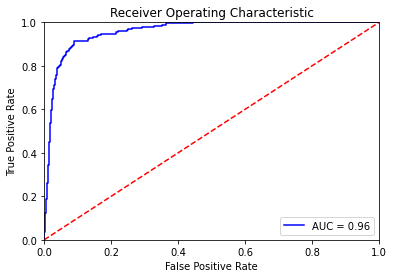

In [24]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5) cut-off 조정해보면서, Model 성능 재확인

In [33]:
xgb_pred2 = (xgb_model.predict_proba(X_test)[:,1]>=0.5).astype(int)
print('f1 score:', f1_score(y_test, xgb_pred2))
    
confusion_matrix(y_test, xgb_pred2)

f1 score: 0.4864864864864864


array([[7188,  253],
       [  51,  144]], dtype=int64)

## 6) feature importance

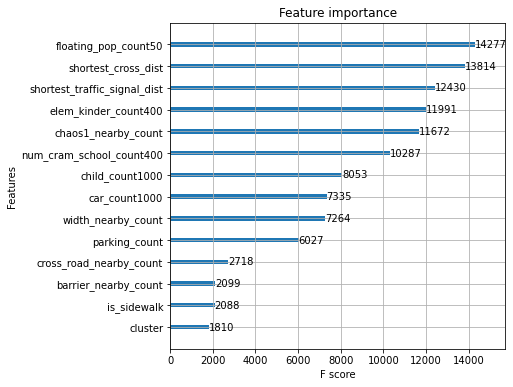

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(xgb_model, ax=ax)

# 3. 결과- 위험지역 뽑아보기

In [27]:
xgb_pred_prob = xgb_model.predict_proba(X_test)

danger_xgb=pd.DataFrame(xgb_pred_prob)
danger_xgb.columns=['No_xgb', 'Yes_xgb']

In [28]:
danger_xgb=pd.concat([data25, danger_xgb], axis=1)
danger_xgb_all=danger_xgb.sort_values(by=['Yes_xgb'], ascending=False)[0:100] #그냥 상위 100개

In [29]:
danger_xgb_without=danger_xgb[danger_xgb['overspeed_cam_count100']==0]
danger_xgb_without=danger_xgb_without.sort_values(by=['Yes_xgb'], ascending=False)[0:100] #카메라 없는 곳 상위 100개

In [30]:
import geopandas as gpd
import json
import folium
from folium import plugins

In [31]:
osan=gpd.read_file("C:/Users/ishon/OneDrive/바탕 화면/SIG_202005/SIG.shp")
osan=osan[osan["SIG_ENG_NM"]=="Osan-si"]
center = (37.1623799231016, 127.05436890115905)
style5 = {'fillColor': 'skyblue', 'color': 'skyblue'}

map_xgb_danger = folium.Map(location=center, zoom_start=12, width=900, height=700, control_scale=True)

#osan
osan_region = plugins.FeatureGroupSubGroup(map_xgb_danger, 'osan region')
map_xgb_danger.add_child(osan_region)
folium.GeoJson(osan, style_function=lambda x:style5).add_to(osan_region)

fg = folium.FeatureGroup(name='groups')
map_xgb_danger.add_child(fg)

g1 = plugins.FeatureGroupSubGroup(fg, 'group1')
map_xgb_danger.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'group2')
map_xgb_danger.add_child(g2)

danger_xgb_all.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                                radius=2, color='blue').add_to(g1), axis=1)

danger_xgb_without.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                               radius=2, color='red').add_to(g2), axis=1)

folium.LayerControl(collapsed=False).add_to(map_xgb_danger)
map_xgb_danger

# 4. 최종 위험도 출력

In [39]:
result=pd.DataFrame(xgb_pred_prob, columns={'No', 'Yes'})
result.to_csv('C:/Users/ishon/OneDrive/바탕 화면/xgboost_result.csv')